<a href="https://colab.research.google.com/github/Ryosuke8030/kimatu/blob/master/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline

In [11]:
from multiprocessing import cpu_count
from pathlib import Path

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [13]:
seed = 1
np.random.seed(seed)

In [14]:
ROOT = Path.cwd()/'input'
SAMPLE = ROOT/'sample_submission.csv'
TRAIN = ROOT/'X_train.csv'
TARGET = ROOT/'y_train.csv'
TEST = ROOT/'X_test.csv'

ID_COLS = ['series_id', 'measurement_number']

x_cols = {
    'series_id': np.uint32,
    'measurement_number': np.uint32,
    'orientation_X': np.float32,
    'orientation_Y': np.float32,
    'orientation_Z': np.float32,
    'orientation_W': np.float32,
    'angular_velocity_X': np.float32,
    'angular_velocity_Y': np.float32,
    'angular_velocity_Z': np.float32,
    'linear_acceleration_X': np.float32,
    'linear_acceleration_Y': np.float32,
    'linear_acceleration_Z': np.float32
}

y_cols = {
    'series_id': np.uint32,
    'group_id': np.uint32,
    'surface': str
}

In [15]:
x_trn = pd.read_csv(TRAIN, usecols=x_cols.keys(), dtype=x_cols)
x_tst = pd.read_csv(TEST, usecols=x_cols.keys(), dtype=x_cols)
y_trn = pd.read_csv(TARGET, usecols=y_cols.keys(), dtype=y_cols)

In [17]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [18]:
class CyclicLR(_LRScheduler):

    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [19]:
def cosine(t_max, eta_min=0):

    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2

    return scheduler

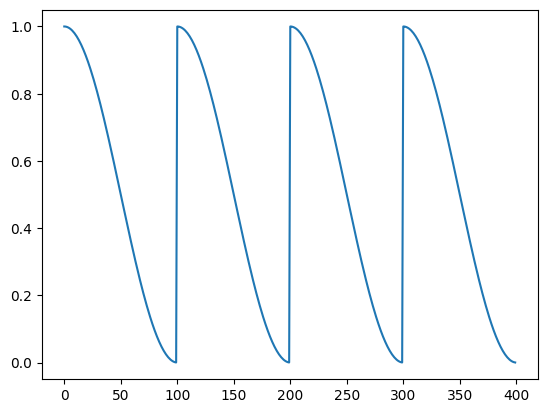

In [20]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [21]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [22]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['surface'])

Preparing datasets


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 1305 has size 90

In [23]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())

Creating data loaders with batch size: 128


NameError: name 'trn_ds' is not defined